# Digital homo- and heterodyne detection

In [1]:
import matplotlib.pyplot as plt

import numpy as np

from qutip import *
from scipy.interpolate import interp1d
from scipy.stats import kstest
from joblib import Parallel, delayed

10

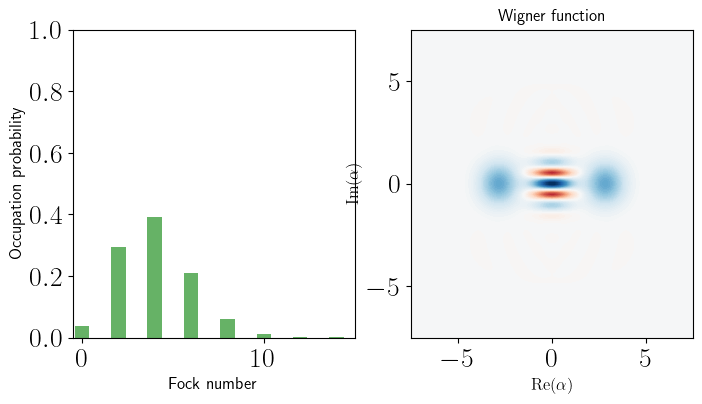

In [175]:
N=15

idc = qeye(N)
ida = qeye(3)
a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(3))

sigmax = Qobj([[0, 1, 0],[1,0,0],[0,0,0]])
sigmay = Qobj([[0, -1j, 0],[1j,0,0],[0,0,0]])
sigmaz = Qobj([[1, 0, 0],[0,-1,0],[0,0,0]])

sx = tensor(idc, sigmax)
sy = tensor(idc, sigmay)
sz = tensor(idc, sigmaz)

# cavity photon number operator
N_cav = tensor(num(N), ida)

# projection operators to qubit ground and excited state
proj0 = tensor(idc, basis(3,0).proj())
proj1 = tensor(idc, basis(3,1).proj())
proj2 = tensor(idc, basis(3,2).proj())

initial_cavity = coherent(N, 1j*1)

initial_cavity = fock(N,4) 

alpha = 2
initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#initial_cavity = (fock(N, 1) + fock(N,2)).unit()

psi0 = tensor(initial_cavity, basis(3,0))

n_init = expect(N_cav, psi0)

plot_wigner_fock_distribution(initial_cavity);
n_max = np.max([i for i,e in enumerate(initial_cavity) if e >= 0.05])
n_max

In [176]:
def H_interact(g):
    op =  g * (a.dag() * sm + a * sm.dag())
    return op 

def H_nonlinear(alpha):
    op = -alpha* sm**2 * sm.dag()**2
    return op 

def U_interact(g,alpha):
    op = -1j * (H_interact(g) + H_nonlinear(alpha))
    return op.expm()

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

## Qubit-dyne params and coupling

In [177]:
Nmeas = 120

g = 0.25
gamma = g**2
dt = 0.5

nsteps = np.linspace(0,Nmeas-1,Nmeas)
tlist = nsteps*dt

In [178]:
# Select quadrature
rotangl = 0
qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

# Time-dependent coupling

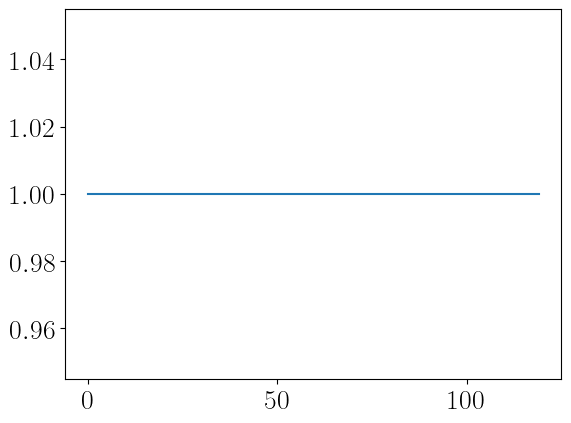

In [179]:
expspeed=0.03 # pick suitable scaling (will be state dependent)

def g_timedep_exp(i):
    return 0.5*np.exp(expspeed*(i)) 

def g_timedep_linear(i):
    return i/5 # pick suitable scaling (will be state dependent)

def g_constant(i):
    return 1

g_timedep = g_constant

g_timedep_list = np.array([g_timedep(i) for i in range(Nmeas)])

#qubit anharmonicity
anharm =0.

U_ints=[]
for i in range(Nmeas):
    U_ints.append(U_interact(g*g_timedep_list[i]*np.sqrt(dt), anharm))
    
plt.plot(g_timedep_list);

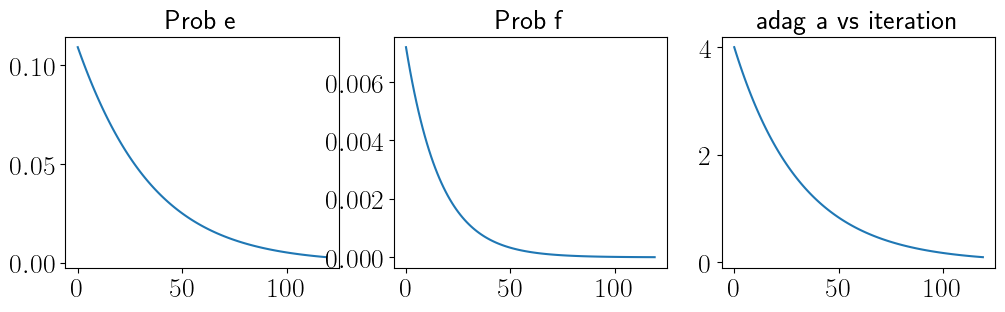

In [180]:
# Find weights by solving unconditional ME
p2exp = []
p1exp = []
n_cav_timedep = []
rho = ket2dm(psi0)

expect_a = []

for i in range(Nmeas):
    
    n_cav_timedep.append(expect(N_cav, rho))
    
    U_int = U_ints[i]
    rho = U_int * rho * U_int.dag()
    
    p1val= expect(proj1, rho)
    p1exp.append(p1val)
    
    p2val= expect(proj2, rho)
    p2exp.append(p2val)
    
    expect_a.append(expect(a,rho))
    
    rho = tensor(rho.ptrace(0),basis(3,0).proj())
    
## Define weights based on scaled qubit excitation probability
weights_timedep=np.sqrt(np.array(p1exp)/(2*n_init)).real

fig, axes = plt.subplots(1, 3, figsize=(12,3))

axes[0].plot(p1exp)
lbl2 = axes[0].set_title("Prob e")

axes[1].plot(p2exp)
lbl2 = axes[1].set_title("Prob f")

axes[2].plot(n_cav_timedep)
lbl2 = axes[2].set_title("adag a vs iteration")

In [181]:
rabi_maxn = np.sqrt((np.array(n_cav_timedep)+1)*g_timedep_list**2*gamma)
n_max*gamma*dt, np.sqrt(n_max*gamma*dt), np.pi/2

(0.3125, 0.5590169943749475, 1.5707963267948966)

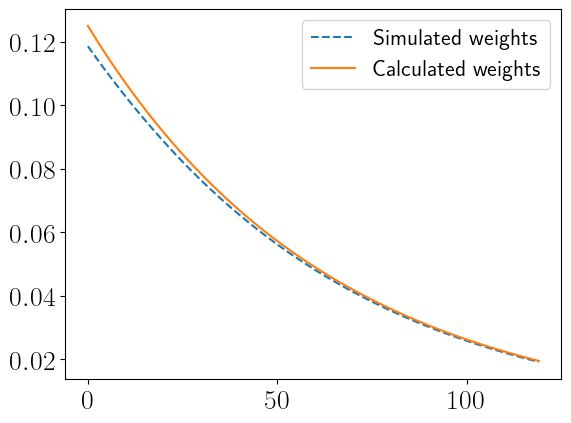

In [174]:
plt.plot(weights_timedep,'--', label='Simulated weights')

def calc_weights(step):
    g_timedep_list = np.array([g_timedep(i) for i in range(step+1)])
    exponent = np.trapz(g_timedep_list**2,dx=dt)
    return  g_timedep(step)*np.sqrt(gamma*dt/2)*np.exp(-gamma*exponent/2)

calculated_weights_timedep = np.array([calc_weights(step) for step in range(Nmeas)])

plt.plot(calculated_weights_timedep, label='Calculated weights')
plt.legend();

## Get histogram

In [163]:
# Repeated homodyne detection: calculate single homodyne shots and collect statistics
Ntrajs = 1000

def get_measurements():
    measurements = []

    # could be parallellized
    for j in range(Ntrajs):
        # no seed, different random number every run
        xrnd = np.random.rand(Nmeas)

        results = []
        psi = psi0

        for i in range(Nmeas):
            psi = qbrotmat * (U_ints[i] * psi)

            prob = expect(proj0,psi)
            if prob>xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi

        measurements.append(np.sum(results*weights_timedep))
    return measurements

0.10711305584702185

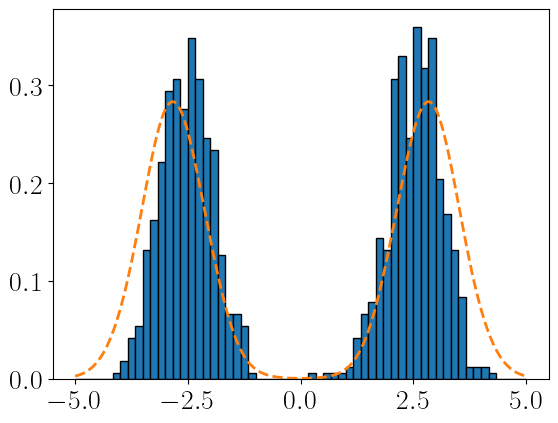

In [164]:
k=5
measurements = get_measurements()
plt.hist(np.array(measurements),60,[-k,k],density=True, edgecolor='k')

x=np.linspace(-k,k,500)

# ideal distribution from Wigner marginal
x=np.linspace(-5,5,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0)
plt.plot(x, marginal, 'C1--',linewidth=2)

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

#Kolmogorov-Smirnov statistic
ks_stat_timedep = kstest(measurements, cdf_func)[0]
ks_stat_timedep

In [149]:
## get statistics
nr_stats = 10

get_stats = True
    
def get_stats_func():
    measurements = get_measurements()
    ks_stat = kstest(measurements, cdf_func)[0]
    return ks_stat

if get_stats == True:
    ks_stats = Parallel(n_jobs=nr_stats)(delayed(get_stats_func)() for i in range(nr_stats))
    mean_ks = np.mean(ks_stats)

print(mean_ks)

0.1131364613214418
